In [1]:
%cd /home/sasedov/StyleDomain/SimilarDomains

/home/sasedov/StyleDomain/SimilarDomains


In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import PIL
import random

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor
from omegaconf import OmegaConf
from core.utils.common import load_clip, mixing_noise
from core.utils.example_utils import (
    Inferencer, to_im, vstack_with_lines, hstack_with_lines, insert_image,
    project_e4e, project_restyle_psp, project_fse_without_image_generation, read_img
)
from core.utils.image_utils import construct_paper_image_grid
from core.utils.reading_weights import read_weights
from core.uda_models import OffsetsTunningGenerator

from pathlib import Path
from collections import defaultdict

from examples.draw_util import weights, set_seed, morph_g_ema, IdentityEditor, StyleEditor

from core.utils.example_utils import read_fse_config

scale, scale_mode, idx_k, n_styles, enc_residual, enc_residual_coeff, resnet_layers, stride = read_fse_config('FeatureStyleEncoder/configs/001.yaml')
print(scale, scale_mode, idx_k, n_styles, enc_residual, enc_residual_coeff, resnet_layers, stride)

/home/sasedov/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2 bilinear 5 18 False False [4, 5, 6] (2, 2)


In [3]:
weights['ffhq']

PosixPath('/home/sasedov/StyleDomain/SimilarDomains/pretrained/StyleGAN2/stylegan2-ffhq-config-f.pt')

In [4]:
def stack_rows(rows, skip_horiz=10, skip_vertical=15):
    final_image = [
        hstack_with_lines(row_stack, skip_horiz) for row_stack in rows
    ]

    final_image = vstack_with_lines(final_image, skip_vertical)
    return PIL.Image.fromarray(final_image)


style_to_editor = {
    d: StyleEditor(read_weights(weights[d])) for d in weights if d not in ['horse', 'car', 'ffhq', 'cat', 'church', 'to_metfaces', 'to_afhqcat', 'to_afhqdog', 'to_mega']
}

style_to_editor['original'] = IdentityEditor()
device = 'cuda:0'

In [31]:
from contextlib import redirect_stdout
from PIL import ImageFont
from visualize import stack_to_grid_with_names, text_on_square_image
import io
import sys

def test_s_domains_on_different_encoders(
        gan_domain, s_domains, domain_ims_or_texts, im,
        w_enc_list, features_list, generator_shift_list,
        image_size=256, verbose=False,
        row_names=None, column_names=None
    ):
    """
        domain_ims_or_texts: list of initial images or text descriptions per each domain, empty images by default
        w_enc_list: list of latents for each encoder
        features_list: list of encoder feature maps for each encoder, should be None by default
        generator_shift_list: list of flags, whether to shift with generator feature maps
    """
    
    if domain_ims_or_texts is None:
        domain_ims_or_texts = [PIL.Image.fromarray(np.zeros_like(im))] * len(s_domains)
    
    resize = Resize(image_size)
    transform = transforms.Compose(
        [
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ]
    )
    
    def prepare_im(im, use_transform=False, unsqueeze=False):
        if use_transform: 
            im = transform(im)
        if unsqueeze:
            im = im.unsqueeze(0)
        return np.array(to_im(resize(im), padding=0))
    
    row_stack = []
    row = []
    inversion_row = []
    
    assert len(w_enc_list) == len(features_list) and len(w_enc_list) == len(generator_shift_list)
    images_per_row = len(w_enc_list) + 1

    if not verbose:
        f_stdout = io.StringIO()

    for i, (s_domain, domain_info) in enumerate(zip(s_domains, domain_ims_or_texts)):
        ckpt = read_weights(weights[s_domain])
        ckpt_ffhq = {'sg2_params': ckpt['sg2_params']}
        ckpt_ffhq['sg2_params']['checkpoint_path'] = weights[gan_domain]

        if not verbose:
            with redirect_stdout(f_stdout):
                model = Inferencer(ckpt, device)
        
        if i == 0:
            inversion_row.append(prepare_im(im, use_transform=True, unsqueeze=True))
        
        if isinstance(domain_info, str):
            row.append(text_on_square_image(
                domain_info, image_size,
                font=ImageFont.truetype("/home/sasedov/Times.ttf", 25 * image_size // 256),
                linewidth=20
            ))
        else:
            row.append(prepare_im(domain_info, use_transform=True, unsqueeze=True))
        
        for j, (w_enc, features, generator_shift) in enumerate(zip(w_enc_list, features_list, generator_shift_list)):
            kwargs = {
                "latents": [w_enc],
                "input_is_latent": True,
                "features_in": features,
                "shift_with_generator_feature_map": generator_shift,
                "offsets_coeffs": None #offsets_coeffs_list[j] if offsets_coeffs_list is not None else None
            }
            if not verbose:
                with redirect_stdout(f_stdout):
                    src, trg = model(**kwargs)
            else:
                src, trg = model(**kwargs)
                
            # add original image and its inversion to row_stack
            if i == 0: 
                inversion_row.append(prepare_im(src))
            row.append(prepare_im(trg))

        # if i == 0:
        #     row_stack.append(inversion_row)
        row_stack.append(row)
        row = []

    # return stack_rows(row_stack)

    return stack_to_grid_with_names(
        imgs_list=row_stack, H=image_size, W=image_size,
        row_names=row_names, column_names=column_names,
        font=ImageFont.truetype("/home/sasedov/Times.ttf", 25 * image_size // 256),
    )

In [8]:
from collections import defaultdict
from contextlib import redirect_stdout
from tqdm import tqdm
import os
import io


def get_image_domains():
    f_stdout = io.StringIO()

    domain_images_path = 'image_domains/'
    domain_images = {}

    for domain_image_filename in tqdm(os.listdir(domain_images_path)):
        if '.' not in domain_image_filename:
            continue
        s_domain, file_ext = domain_image_filename.split('.')
        if file_ext in ['png', 'jpg'] and s_domain != 'anime' and s_domain in weights:
            with redirect_stdout(f_stdout):
                domain_images[s_domain] = read_img(domain_images_path + domain_image_filename, align_input=False)

    domain_images = domain_images.items()
    s_domains = [x[0] for x in domain_images]
    domain_ims = [x[1] for x in domain_images]

    ignored_image_domains = ['joker', 'sketch']
    for domain in ignored_image_domains:
        if domain in s_domains:
            ind = s_domains.index(domain)
            s_domains.pop(ind)
            domain_ims.pop(ind)

    print('Considering the following image domains:', *s_domains)
    return s_domains, domain_ims

In [9]:
import yaml
from pathlib import Path

def get_text_domains(domain_dir_path='pretrained/checkpoints_iccv'):
    path = Path(domain_dir_path)
    
    s_domains = []
    domain_texts = []
    
    for domain_dir in tqdm(path.iterdir()):
        with open(domain_dir / 'config.yaml', 'r') as file:
            domain_config = yaml.safe_load(file)
        
        if domain_config['training']['target_class'][-4:] not in ['.png', '.jpg']:
            s_domains.append(domain_dir.name[:-7])  # cut out _sdelta in the end
            domain_texts.append(domain_config['training']['target_class'])
            if 'indomain' in s_domains[-1]:
                domain_texts[-1] += ' (indomain)'

    print('Considering the following text domains:', *s_domains)
    return s_domains, domain_texts

In [12]:
im_domains, domain_ims = get_image_domains()

100%|██████████| 37/37 [00:00<00:00, 771.64it/s]

Considering the following image domains: jojo nigelwy_untitled_artwork_18 digital_painting_jing titan_armin oliver_wetter_corie_lynn_concept_1_final_back_web murasaki_nora_asuya disney_princess remi_castaneda_sean_connery_final stanislav_galai_04_23 anastasia maria_trepalina_img_6833_1 rain_artwork_dtiyschallennge mermaid truc_huynh_hex_009v2 speed_paint naufal_ilyasa_seraphine_ig_full_res rich_d_amaru_studyfinal ricardo_viana_render2 wesley_gardner_portraitstudy titan_erwin


In [13]:
text_domains, domain_texts = get_text_domains()

76it [00:02, 32.63it/s]

Considering the following text domains: edvard_munch_painting the_thanos tolkien_elf_indomain neanderthal_indomain modigliani_painting sketch hulk minimalist_drawing zombie_indomain pop_art_indomain pixar hulk_indomain edvard_munch_painting_indomain frida_kahlo_painting hermione_granger claude_monet_painting dali_painting neanderthal ukiyo-e botero_indomain frida_kahlo_painting_indomain impressionist_drawing_indomain werewolf_indomain impressionism_painting_indomain dali_painting_indomain botero modigliani_painting_indomain constructivism_indomain impressionist_drawing constructivism minimalist_drawing_indomain joker pop_art anime_indomain anime tolkien_elf werewolf ukiyo-e_indomain zombie impressionism_painting disney_princess_indomain disney_princess hermione_granger_indomain cubism_painting_indomain sketch_indomain claude_monet_painting_indomain cubism_painting the_thanos_indomain pixar_indomain joker_indomain


In [14]:
s_domains = im_domains + text_domains

In [15]:
domain_ims_or_texts = domain_ims + domain_texts

In [16]:
# MEASURE LAYER OFFSETS FOR EACH DOMAIN
def measure_offset_norms_by_layer(s_domains):
    gan_domain = 'ffhq'
    # s_domains.append('pop_art_indomain')

    layer_offsets_by_domain = {}
    mean_layer_norms = defaultdict(float)

    for s_domain in s_domains:
        print(f'\nDOMAIN {s_domain}:')
        ckpt = read_weights(weights[s_domain])
        ckpt_ffhq = {'sg2_params': ckpt['sg2_params']}
        ckpt_ffhq['sg2_params']['checkpoint_path'] = weights[gan_domain]

        model = Inferencer(ckpt, device)

        layer_offsets_by_domain[s_domain] = {}
        for layer_name, layer_value in model.model_da().items():
            layer_norm = layer_value['in'].norm().detach().cpu().numpy()
            print(f'{layer_name}: {layer_norm}, layer_value.shape: {layer_value["in"].shape}')

            mean_layer_norms[layer_name] += layer_norm
            layer_offsets_by_domain[s_domain][layer_name] = layer_value['in'].detach()

    print(f'\nMean layer norms across selected s_domains:')
    for layer_name, layer_norm in mean_layer_norms.items():
        mean_layer_norms[layer_name] = layer_norm / len(mean_layer_norms)
        print(f'{layer_name}: {mean_layer_norms[layer_name]}')
    
    return mean_layer_norms, layer_offsets_by_domain

In [17]:
# mean_layer_norms, layer_offsets_by_domain = measure_offset_norms_by_layer(im_domains + text_domains)

In [18]:
e4e_offsets_coeffs = [
    0.7250403761863708,
    0.2626339495182037,
    0.6552985906600952,
    0.7303584218025208,
    0.6811474561691284,
    0.7767353653907776,
    0.9527875781059265,
    0.9049936532974243,
    0.8513546586036682,
    0.7799299359321594,
    1.1332719326019287,
    0.7100310325622559,
    0.7962964177131653,
    0.6757728457450867,
    0.7018265724182129,
    0.6636937856674194,
    0.6807562708854675,
    0.6779585480690002
]

fse_offsets_coeffs = [
    0.46660858392715454,
    0.00757311424240469,
    0.4669175148010254,
    0.7105019092559814,
    0.9221417307853699,
    0.6862319111824036,
    1.1542936563491821,
    0.8920652866363525,
    1.0488144159317017,
    0.5729503631591797,
    1.4492567777633667,
    0.6482011675834656,
    1.731235384941101,
    0.5105834603309631,
    1.0992273092269897,
    0.5512086153030396,
    0.8076189160346985,
    0.6648847460746765
]
e4e_offsets_coeffs = [1 / x for x in e4e_offsets_coeffs]
fse_offsets_coeffs = [1 / x for x in fse_offsets_coeffs]

offsets_coeffs_list = [
    None, e4e_offsets_coeffs,
    None, fse_offsets_coeffs,
    None, fse_offsets_coeffs,
    None, fse_offsets_coeffs
]

In [27]:
indices = [
    i for i, s_domain in enumerate(im_domains)
    if s_domain in ["murasaki_nora_asuya", "rich_d_amaru_studyfinal"]
    # if s_domain in ["oliver_wetter_corie_lynn_concept_1_final_back_web", "titan_armin"]
]

tmp_im_domains = [im_domains[i] for i in indices]
tmp_domain_ims = [domain_ims[i] for i in indices]

indices = [
    i for i, s_domain in enumerate(text_domains)
    # if s_domain in ["murasaki_nora_asuya"]
    if s_domain in ["hulk", "frida_kahlo_painting", "modigliani_painting", "modigliani_painting_indomain"]
]
indices.insert(1, indices[-1])
indices.pop()

tmp_text_domains = [text_domains[i] for i in indices]
tmp_domain_texts = [domain_texts[i] for i in indices]

In [29]:
# TESTING OFFSETS COEFFS

import os
import numpy as np

gan_domain = 'ffhq'

# image_path = '/home/sasedov/misha.jpg'
image_path = 'examples/photos/01703.png'
im = read_img(image_path, align_input=True)

w_e4e = project_e4e(im, 'pretrained/e4e_ffhq_encode.pt')[1]
empty_img, w_fse, fse_features = project_fse_without_image_generation(
    im,
    model_path='pretrained/143_enc.pth',
    fse_config_name='001',
    arcface_model_path='pretrained/backbone.pth',
    stylegan_model_path='pretrained/StyleGAN2/stylegan2-ffhq-config-f.pt'
)

print('List of used encoders:')
print('1) E4E latents')
print('2) FSE with latents only')
print('3) FSE with latents and feature map')
print('4) FSE with latents, feature map and generator shift')

result = test_s_domains_on_different_encoders(
    gan_domain,
    s_domains=tmp_im_domains + tmp_text_domains,
    domain_ims_or_texts=tmp_domain_ims + tmp_domain_texts,
    im=im,
    w_enc_list=[w_e4e, w_e4e, w_fse, w_fse, w_fse, w_fse, w_fse, w_fse],
    features_list=[None, None, None, None, fse_features, fse_features, fse_features, fse_features], 
    generator_shift_list=[False, False, False, False, False, False, True, True],
    image_size=256, verbose=False,
    column_names=[
        "orig",
        "e4e latents", "e4e latents coeffs",
        "fse latents", "fse latents coeffs",
        "fse features", "fse features coeffs",
        "fse gen shift", "fse gen shift coeffs"
    ]
)

name='1703_selected'
result.save(f'encoders_comparison_results/offsets_coeffs/{name}_encoders_comparison_on_s_domains.pdf', save_all=True, append_images=[])
result.save(f'encoders_comparison_results/offsets_coeffs/{name}_encoders_comparison_on_s_domains.jpg')
# result

Aligned image has shape: (1024, 1024)
Loading e4e over the pSp framework from checkpoint: pretrained/e4e_ffhq_encode.pt
torch.Size([3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([3, 1024, 1024])
torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 256, 256])
List of used encoders:
1) E4E latents
2) FSE with latents only
3) FSE with latents and feature map
4) FSE with latents, feature map and generator shift
225 24
225 24
127 25
57 19
240 24


In [32]:
indices = [
    i for i, s_domain in enumerate(im_domains)
    if s_domain in []
    # if s_domain in ["oliver_wetter_corie_lynn_concept_1_final_back_web", "titan_armin"]
]

tmp_im_domains = [im_domains[i] for i in indices]
tmp_domain_ims = [domain_ims[i] for i in indices]

indices = [
    i for i, s_domain in enumerate(text_domains)
    # if s_domain in ["murasaki_nora_asuya"]
    if s_domain in ["frida_kahlo_painting", "hermione_granger", "claude_monet_painting", "dali_painting"]
]

tmp_text_domains = [text_domains[i] for i in indices]
tmp_domain_texts = [domain_texts[i] for i in indices]

In [34]:
# HEADINGS FOR SCREENSHOTS

import os
import numpy as np

gan_domain = 'ffhq'

image_path = 'examples/photos/01703.png'
im = read_img(image_path, align_input=True)

w_e4e = project_e4e(im, 'pretrained/e4e_ffhq_encode.pt')[1]
empty_img, w_fse, fse_features = project_fse_without_image_generation(
    im,
    model_path='pretrained/143_enc.pth',
    fse_config_name='001',
    arcface_model_path='pretrained/backbone.pth',
    stylegan_model_path='pretrained/StyleGAN2/stylegan2-ffhq-config-f.pt'
)

print('List of used encoders:')
print('1) E4E latents')
print('2) FSE with latents only')
print('3) FSE with latents and feature map')
print('4) FSE with latents, feature map and generator shift')

result = test_s_domains_on_different_encoders(
    gan_domain,
    s_domains=tmp_text_domains,
    domain_ims_or_texts=tmp_domain_texts,
    im=im,
    w_enc_list=[w_e4e, w_fse, w_fse, w_fse],
    features_list=[None, None, fse_features, fse_features], 
    generator_shift_list=[False, False, False, True],
    image_size=1024, verbose=False,
    column_names=["orig", "e4e latents", "fse latents", "fse features", "fse generator shift"]
)

name='1703_text_domains'
result.save(f'encoders_comparison_results/tests/headings/{name}.pdf', save_all=True, append_images=[])
result.save(f'encoders_comparison_results/tests/headings/{name}.jpg')
# result

Aligned image has shape: (1024, 1024)
Loading e4e over the pSp framework from checkpoint: pretrained/e4e_ffhq_encode.pt
torch.Size([3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([3, 1024, 1024])
torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 256, 256])
List of used encoders:
1) E4E latents
2) FSE with latents only
3) FSE with latents and feature map
4) FSE with latents, feature map and generator shift
961 95
864 95
652 97
654 76
375 95
605 95


In [11]:
import os
import numpy as np

gan_domain = 'ffhq'

# image_path = '/home/sasedov/misha.jpg'
image_path = 'examples/photos/01703.png'
im = read_img(image_path, align_input=True)

w_e4e = project_e4e(im, 'pretrained/e4e_ffhq_encode.pt')[1]
empty_img, w_fse, fse_features = project_fse_without_image_generation(
    im,
    model_path='pretrained/143_enc.pth',
    fse_config_name='001',
    arcface_model_path='pretrained/backbone.pth',
    stylegan_model_path='pretrained/StyleGAN2/stylegan2-ffhq-config-f.pt'
)

print('List of used encoders:')
print('1) E4E latents')
print('2) FSE with latents only')
print('3) FSE with latents and feature map')
print('4) FSE with latents, feature map and generator shift')

result = test_s_domains_on_different_encoders(
    gan_domain,
    s_domains=im_domains + text_domains,
    domain_ims_or_texts=domain_ims + domain_texts,
    im=im,
    w_enc_list=[w_e4e, w_fse, w_fse, w_fse],
    features_list=[None, None, fse_features, fse_features], 
    generator_shift_list=[False, False, False, True],
    image_size=256, verbose=False,
    column_names=["orig", "e4e latents", "fse latents", "fse features", "fse generator shift"]
)

name='blue_headscarf_01703'
result.save(f'encoders_comparison_results/tests/{name}_encoders_comparison_on_s_domains.pdf', save_all=True, append_images=[])
result.save(f'encoders_comparison_results/tests/{name}_encoders_comparison_on_s_domains.jpg')
# result

KeyboardInterrupt: 

In [22]:
import os
import numpy as np

gan_domain = 'ffhq'

image_path = '/home/sasedov/misha.jpg'
im = read_img(image_path, align_input=True)

w_e4e = project_e4e(im, 'pretrained/e4e_ffhq_encode.pt')[1]
empty_img, w_fse, fse_features = project_fse_without_image_generation(
    im,
    model_path='pretrained/143_enc.pth',
    fse_config_name='001',
    arcface_model_path='pretrained/backbone.pth',
    stylegan_model_path='pretrained/StyleGAN2/stylegan2-ffhq-config-f.pt'
)

print('List of used encoders:')
print('1) E4E latents')
print('2) FSE with latents only')
print('3) FSE with latents and feature map')
print('4) FSE with latents, feature map and generator shift')

result = test_s_domains_on_different_encoders(
    gan_domain,
    s_domains=text_domains,
    domain_ims_or_texts=domain_texts,
    im=im,
    w_enc_list=[w_e4e, w_fse, w_fse, w_fse],
    features_list=[None, None, fse_features, fse_features], 
    generator_shift_list=[False, False, False, True],
    image_size=1024, verbose=False,
    column_names=["orig", "e4e latents", "fse latents", "fse features", "fse generator shift"]
)

name='misha_text_domains'
result.save(f'encoders_comparison_results/{name}_encoders_comparison_on_s_domains.pdf', save_all=True, append_images=[])
result.save(f'encoders_comparison_results/{name}_encoders_comparison_on_s_domains.jpg')
# result

Aligned image has shape: (1024, 1024)
Loading e4e over the pSp framework from checkpoint: pretrained/e4e_ffhq_encode.pt
torch.Size([3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([3, 1024, 1024])
torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 256, 256])
List of used encoders:
1) E4E latents
2) FSE with latents only
3) FSE with latents and feature map
4) FSE with latents, feature map and generator shift


In [12]:
import os
import numpy as np

gan_domain = 'ffhq'

image_path = '/home/sasedov/luka2-square.jpg'
im = read_img(image_path, align_input=False)

w_e4e = project_e4e(im, 'pretrained/e4e_ffhq_encode.pt')[1]
empty_img, w_fse, fse_features = project_fse_without_image_generation(
    im,
    model_path='pretrained/143_enc.pth',
    fse_config_name='001',
    arcface_model_path='pretrained/backbone.pth',
    stylegan_model_path='pretrained/StyleGAN2/stylegan2-ffhq-config-f.pt'
)

print('List of used encoders:')
print('1) E4E latents')
print('2) FSE with latents only')
print('3) FSE with latents and feature map')
print('4) FSE with latents, feature map and generator shift')

result = test_s_domains_on_different_encoders(
    gan_domain,
    s_domains=im_domains + text_domains,
    domain_ims_or_texts=domain_ims + domain_texts,
    im=im,
    w_enc_list=[w_e4e, w_fse, w_fse, w_fse],
    features_list=[None, None, fse_features, fse_features], 
    generator_shift_list=[False, False, False, True],
    image_size=256, verbose=False,
    column_names=["orig", "e4e latents", "fse latents", "fse features", "fse generator shift"]
)

name='luka_all_domains'
result.save(f'encoders_comparison_results/{name}_encoders_comparison_on_s_domains.pdf', save_all=True, append_images=[])
result.save(f'encoders_comparison_results/{name}_encoders_comparison_on_s_domains.jpg')
# result

Loading e4e over the pSp framework from checkpoint: pretrained/e4e_ffhq_encode.pt
torch.Size([3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([3, 1024, 1024])
torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 256, 256])
List of used encoders:
1) E4E latents
2) FSE with latents only
3) FSE with latents and feature map
4) FSE with latents, feature map and generator shift


In [ ]:
# DOMAIN COMPARISON ON THE CLIP-BASED QUALITY METRIC DIFF FOR FSE_WITH_FEATURES AND E4E

In [35]:
domain_types = {}

for domain_type in ['all', 'image', 'text']:
    domain_types[domain_type] = {}
    for domain_quality_type in ['diff', 'mid', 'sim']:
        type_filestr = '' if domain_type == 'all' else domain_type + '_'
        
        with open(f'domain_encoder_metrics/{type_filestr}{domain_quality_type}_domains_list.txt', 'r') as f:
            domain_types[domain_type][domain_quality_type] = set()
            
            for line in f.readlines():
                s_domain = line.strip().split(' ')[0]
                
                if domain_type == 'image' and s_domain in ignored_image_domains:
                    continue
                
                domain_types[domain_type][domain_quality_type].add(s_domain)

In [36]:
domain_indices_by_type = {}
s_domains_by_type = {}
domain_ims_or_texts_by_type = {}

for domain_type, domain_groups in domain_types.items():
    domain_indices_by_type[domain_type] = {}
    s_domains_by_type[domain_type] = {}
    domain_ims_or_texts_by_type[domain_type] = {}
    
    for key, domains in domain_groups.items():
        domain_indices_by_type[domain_type][key] = [i for i, d in enumerate(s_domains) if d in domains]
        s_domains_by_type[domain_type][key] = [s_domains[i] for i in domain_indices_by_type[domain_type][key]]
        domain_ims_or_texts_by_type[domain_type][key] = [domain_ims_or_texts[i] for i in domain_indices_by_type[domain_type][key]]

In [37]:
domain_indices_by_type['image']['diff'], len(im_domains)

([0, 1, 3, 8, 12, 14, 16, 18, 19], 20)

In [38]:
domain_indices_by_type['text']['diff']

[24, 34, 36, 37, 38, 45, 46, 55, 56, 62]

In [39]:
# BY DOMAIN_TYPE ['ALL', 'IMAGE', 'TEXT'] AND DOMAIN_QUALITY_TYPE IN ['DIFF', 'MID', 'SIM']

NAME = 'BLUE_HEADSCARF_01703'
WRITE_DIR_PATH = 'encoders_comparison_results/domains_by_type_comparison'

import os
import numpy as np

gan_domain = 'ffhq'

# image_path = '/home/sasedov/luka2-square.jpg'
image_path = 'examples/photos/01703.png'
im = read_img(image_path, align_input=False)

w_e4e = project_e4e(im, 'pretrained/e4e_ffhq_encode.pt')[1]
empty_img, w_fse, fse_features = project_fse_without_image_generation(
    im,
    model_path='pretrained/143_enc.pth',
    fse_config_name='001',
    arcface_model_path='pretrained/backbone.pth',
    stylegan_model_path='pretrained/StyleGAN2/stylegan2-ffhq-config-f.pt'
)

print('List of used encoders:')
print('1) E4E latents')
print('2) FSE with latents only')
print('3) FSE with latents and feature map')
print('4) FSE with latents, feature map and generator shift')

for DOMAIN_TYPE in ['all', 'image', 'text']:
    for DOMAIN_QUALITY_TYPE in ['diff', 'mid', 'sim']:
        print(f'Processing {DOMAIN_TYPE} domains of {DOMAIN_QUALITY_TYPE} quality type...')

        result = test_s_domains_on_different_encoders(
            gan_domain,
            s_domains=s_domains_by_type[DOMAIN_TYPE][DOMAIN_QUALITY_TYPE],
            domain_ims_or_texts=domain_ims_or_texts_by_type[DOMAIN_TYPE][DOMAIN_QUALITY_TYPE],
            im=im,
            w_enc_list=[w_e4e, w_fse, w_fse, w_fse],
            features_list=[None, None, fse_features, fse_features], 
            generator_shift_list=[False, False, False, True],
            image_size=256, verbose=False,
            column_names=["orig", "e4e latents", "fse latents", "fse features", "fse generator shift"]
        )

        filepath = f'{WRITE_DIR_PATH}/{DOMAIN_TYPE}/{DOMAIN_QUALITY_TYPE}_domains_{NAME}_encoders_comparison_on_s_domains'
        result.save(f'{filepath}.pdf', save_all=True, append_images=[])
        result.save(f'{filepath}.jpg')
        print(f'Saved results to {filepath} in .pdf and .jpg !')
        # result

Loading e4e over the pSp framework from checkpoint: pretrained/e4e_ffhq_encode.pt
torch.Size([3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([3, 1024, 1024])
torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 256, 256])
List of used encoders:
1) E4E latents
2) FSE with latents only
3) FSE with latents and feature map
4) FSE with latents, feature map and generator shift
Processing all domains of diff quality type...
Saved results to encoders_comparison_results/domains_by_type_comparison/all/diff_domains_BLUE_HEADSCARF_01703_encoders_comparison_on_s_domains in .pdf and .jpg !
Processing all domains of mid quality type...
Saved results to encoders_comparison_results/domains_by_type_comparison/all/mid_domains_BLUE_HEADSCARF_01703_encoders_comparison_on_s_domains in .pdf and .jpg !
Processing all domains of sim quality type...
Saved results to encoders_comparison_results/domains_by_type_comparison/all/sim_domains_BLUE_HEADSCARF_01703_encoders_comparison_on_s_domains in .pdf and .jpg !


In [42]:
!zip -r domains_by_type_comparison.zip encoders_comparison_results/domains_by_type_comparison/

  adding: encoders_comparison_results/domains_by_type_comparison/ (stored 0%)
  adding: encoders_comparison_results/domains_by_type_comparison/sim_domains_luka_all_domains_encoders_comparison_on_s_domains.jpg (deflated 2%)
  adding: encoders_comparison_results/domains_by_type_comparison/sim_domains_BLUE_HEADSCARF_01703_encoders_comparison_on_s_domains.jpg (deflated 1%)
  adding: encoders_comparison_results/domains_by_type_comparison/mid_domains_BLUE_HEADSCARF_01703_encoders_comparison_on_s_domains.pdf (deflated 2%)
  adding: encoders_comparison_results/domains_by_type_comparison/mid_domains_BLUE_HEADSCARF_01703_encoders_comparison_on_s_domains.jpg (deflated 2%)
  adding: encoders_comparison_results/domains_by_type_comparison/.ipynb_checkpoints/ (stored 0%)
  adding: encoders_comparison_results/domains_by_type_comparison/.ipynb_checkpoints/diff_domains_luka_all_domains_encoders_comparison_on_s_domains-checkpoint.pdf (deflated 2%)
  adding: encoders_comparison_results/domains_by_type_com

In [43]:
!zip -r domain_encoder_metrics.zip domain_encoder_metrics/

  adding: domain_encoder_metrics/ (stored 0%)
  adding: domain_encoder_metrics/domain_encoder_metrics_.txt (deflated 86%)
  adding: domain_encoder_metrics/mean_encoder_metrics_by_domains_2.csv (deflated 63%)
  adding: domain_encoder_metrics/image_sim_domains_list.txt (deflated 27%)
  adding: domain_encoder_metrics/text_sim_domains_list.txt (deflated 70%)
  adding: domain_encoder_metrics/.ipynb_checkpoints/ (stored 0%)
  adding: domain_encoder_metrics/.ipynb_checkpoints/domain_encoder_metrics_-checkpoint.txt (deflated 86%)
  adding: domain_encoder_metrics/.ipynb_checkpoints/text_mid_domains_list-checkpoint.txt (deflated 67%)
  adding: domain_encoder_metrics/.ipynb_checkpoints/text_domain_encoder_metrics-checkpoint.txt (deflated 88%)
  adding: domain_encoder_metrics/.ipynb_checkpoints/text_sim_domains_list-checkpoint.txt (deflated 70%)
  adding: domain_encoder_metrics/.ipynb_checkpoints/diff_domains_list-checkpoint.txt (stored 0%)
  adding: domain_encoder_metrics/.ipynb_checkpoints/image

/tmp/job-1911463/ipykernel_268044/4180398877.py:10: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  width, height = font.getsize(line)


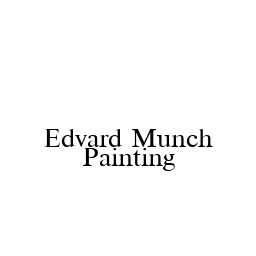

In [ ]:
# MOVED TO VISUALIZE.PY

import textwrap

def text_on_square_image(text, image_size, font=ImageFont.truetype("/home/sasedov/Times.ttf", 25)):
    im = Image.new('RGB', (image_size, image_size), (255, 255, 255))
    draw = ImageDraw.Draw(im)
    
    y_text = image_size / 2
    lines = textwrap.wrap(text, width=20)
    for line in lines:
        width, height = font.getsize(line)
        draw.text(((image_size - width) / 2, y_text), line, font=font, fill='black')
        y_text += height
    
    # draw.text(((image_size - w) / 2, (image_size - h) / 2), text, font=font, fill='black')
    return np.array(im)
    
Image.fromarray(text_on_square_image("Edvard Munch Painting", image_size=256))

In [12]:
ws_e4e = torch.load(f"ws_e4e_tensor.pt", map_location='cuda:0')
ws_fse = torch.load(f"ws_fse_tensor.pt", map_location='cuda:0')
fse_features_tensor = torch.load("fse_features_tesnor.pt", map_location=device)
orig_features_tensor_src = torch.load("orig_features_tensor_src.pt", map_location=device)
orig_features_tensor_trg = torch.load("orig_features_tensor_trg.pt", map_location=device)

filenames = []
with open('latent_corr_exp_filenames.txt', 'r') as f:
    for line in f.readlines():
        filenames.append(line.strip())

In [13]:
import os
import numpy as np

gan_domain = 'ffhq'
hard_image_indices = [316, 837, 704, 1985, 839]

dataset_path = '/home/sasedov/StyleDomain/faces_dataset_small/'

domain_images_path = 'image_domains/'
domain_images = {}

for domain_image_filename in os.listdir(domain_images_path):
    s_domain, file_ext = domain_image_filename.split('.')
    if file_ext in ['png', 'jpg'] and s_domain != 'anime' and s_domain in weights:
        print(s_domain, file_ext)
        domain_images[s_domain] = read_img(domain_images_path + domain_image_filename, align_input=True)

domain_images = domain_images.items()
s_domains = [x[0] for x in domain_images]
domain_ims = [x[1] for x in domain_images]

print('Considering the following domains:', *s_domains)

for image_ind in hard_image_indices:

    image_path = dataset_path + filenames[image_ind]
    im = read_img(image_path, align_input=True)

    w_e4e = project_e4e(im, 'pretrained/e4e_ffhq_encode.pt')[1]
    empty_img, w_fse, fse_features = project_fse_without_image_generation(
        im,
        model_path='pretrained/143_enc.pth',
        fse_config_name='001',
        arcface_model_path='pretrained/backbone.pth',
        stylegan_model_path='pretrained/StyleGAN2/stylegan2-ffhq-config-f.pt'
    )

    print('List of used encoders:')
    print('1) E4E latents')
    print('2) FSE with latents only')
    print('3) FSE with latents and feature map')
    print('4) FSE with latents, feature map and generator shift')

    result = test_s_domains_on_different_encoders(
        gan_domain, s_domains, domain_ims=domain_ims, im=im,
        w_enc_list=[w_e4e, w_fse, w_fse, w_fse],
        features_list=[None, None, fse_features, fse_features], 
        generator_shift_list=[False, False, False, True],
        image_size=256, verbose=False
    )
    result.save(f'img_{image_ind}_encoders_comparison_on_s_domains.pdf', save_all=True, append_images=[])
    result.save(f'img_{image_ind}_encoders_comparison_on_s_domains.jpg')
    print(f'Saved results for {image_ind}!')

jojo png
Aligned image has shape: (1024, 1024)
nigelwy_untitled_artwork_18 jpg
Aligned image has shape: (1024, 1024)
digital_painting_jing png


KeyboardInterrupt: 